<a href="https://colab.research.google.com/github/ilirsheraj/DUDL/blob/main/Chapter_12_Weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

import sklearn.metrics as skm

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats("svg")

##Create a Model and Inspect Weight Matrix Sizes

In [ ]:
# Build a model
aModel = nn.Sequential(
    nn.Linear(10,14), # Input
    nn.Linear(14,19), # Hidden
    nn.Linear(19,8),  # Output
    )

aModel

Sequential(
  (0): Linear(in_features=10, out_features=14, bias=True)
  (1): Linear(in_features=14, out_features=19, bias=True)
  (2): Linear(in_features=19, out_features=8, bias=True)
)

In [ ]:
# print the sizes of the weight matrices in each layer
for i in range(len(aModel)):
    print(aModel[i].weight.shape)

torch.Size([14, 10])
torch.Size([19, 14])
torch.Size([8, 19])


In [ ]:
# Build a model with inconsitent layer shapes
# Build a model
M2 = nn.Sequential(
    nn.Linear(10,14), # Input
    nn.Linear(14,9), # Hidden
    nn.Linear(19,8),  # Output
    )

M2

Sequential(
  (0): Linear(in_features=10, out_features=14, bias=True)
  (1): Linear(in_features=14, out_features=9, bias=True)
  (2): Linear(in_features=19, out_features=8, bias=True)
)

In [ ]:
# print the sizes of the weight matrices in each layer
for i in range(len(M2)):
    print(M2[i].weight.shape)

torch.Size([14, 10])
torch.Size([9, 14])
torch.Size([8, 19])


### Test both models with fake data

In [ ]:
# generate the data
nsamples = 5
nfeatures = 10
fakedata = torch.randn(nsamples, nfeatures)
fakedata

tensor([[ 0.7558,  2.2811, -0.4910, -1.2421, -0.7707, -0.5284,  0.3531, -0.2226,
          0.1212,  0.3177],
        [-1.5399, -0.7987, -0.1539,  0.8338, -0.1644,  0.8212, -1.4080, -1.9678,
          0.0192,  1.8676],
        [ 0.8841, -1.4054,  0.0936, -0.7689, -0.7687, -0.4409,  0.2208, -1.8608,
          0.3293, -0.0167],
        [-0.1972, -2.1446, -0.8011, -2.0125,  0.8249,  1.0730, -0.9423, -0.3212,
         -0.5166,  0.6930],
        [-1.0528, -0.2229, -0.3939, -0.1080, -0.6102, -1.4466,  0.0595, -0.2417,
          0.9306, -1.1521]])

In [ ]:
# Test the first model
aModel(fakedata).shape

torch.Size([5, 8])

In [ ]:
# Test the second model: It will fail!
# M2(fakedata).shape

## Demo on Weight Initialization

In [2]:
# Import the small MNIST dataset that comes with colab
data = np.loadtxt(open("sample_data/mnist_train_small.csv", "rb"),delimiter=",")

# Extract the labels and remove them from data
labels = data[:,0]
data = data[:,1:]

# Normalize data on range 0-1
dataNorm = data/np.max(data)

In [3]:
# COnvert the data into tensors
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()

# Split
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size=0.1)

# Convert into Pytorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Translate into dataLoader objects
batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [4]:
# Create the architecture class
def createTheMNISTNet():

    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Input layer
            self.input = nn.Linear(784, 64)

            # Hidden Layers
            self.fc1 = nn.Linear(64, 32)
            self.fc2 = nn.Linear(32, 32)

            # Output Layer
            self.output = nn.Linear(32,10)

        # Forward Pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))

            return self.output(x)

    # Create an instance
    net = mnistNet()

    # Define the loss function
    lossfun = nn.CrossEntropyLoss()

    # Define the optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

    return net, lossfun, optimizer

In [5]:
# Check out the weights
tmpnet = createTheMNISTNet()[0]
print(tmpnet)

mnistNet(
  (input): Linear(in_features=784, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)


In [20]:
print("Weights for Input Layer:")
print(tmpnet.input.weight.data)
print(tmpnet.input.weight.shape)

Weights for Input Layer:
tensor([[-0.0035,  0.0180,  0.0157,  ...,  0.0095,  0.0219, -0.0302],
        [ 0.0125, -0.0108, -0.0302,  ..., -0.0236, -0.0038,  0.0134],
        [-0.0282,  0.0180,  0.0008,  ...,  0.0119,  0.0133, -0.0196],
        ...,
        [ 0.0126,  0.0198, -0.0353,  ...,  0.0245, -0.0046, -0.0113],
        [-0.0286, -0.0080, -0.0253,  ..., -0.0256,  0.0014,  0.0129],
        [-0.0193, -0.0231, -0.0165,  ..., -0.0180, -0.0312, -0.0090]])
torch.Size([64, 784])


In [8]:
print("Weights for layer fc1:")
print(tmpnet.fc1.weight.data)
print(tmpnet.fc1.weight.shape)

Weights for layer fc1:
tensor([[ 0.0233,  0.0604,  0.0710,  ..., -0.0521,  0.0390, -0.0405],
        [ 0.0328, -0.1105,  0.0497,  ...,  0.1093, -0.0930,  0.0670],
        [-0.0106,  0.1094,  0.1159,  ..., -0.0893,  0.1245, -0.0341],
        ...,
        [-0.1091,  0.0445, -0.0374,  ...,  0.0805,  0.1230,  0.0327],
        [-0.1182, -0.0474,  0.0172,  ...,  0.0335, -0.0435,  0.1198],
        [ 0.0974,  0.1041,  0.0003,  ..., -0.0797,  0.0375,  0.1207]])
torch.Size([32, 64])


In [29]:
# Create a function to train the model
def function2trainTheModel(net, lossfun, optimizer):

    numepochs = 10

    # Initialize the losses
    losses = torch.zeros((numepochs, 2))
    trainAcc = []
    testAcc = []

    # Loop over the epochs
    for epochi in range(numepochs):

        # Switch the training mode on
        net.train()

        # Loop over the batches
        batchAcc = []
        batchLoss = []
        for X,y in train_loader:

            # forward pass
            yHat = net(X)
            loss = lossfun(yHat,y)

            # BackProp
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss and accuracy of each batch
            batchLoss.append(loss.item())
            batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))

        # End of the batch loop 
        trainAcc.append(np.mean(batchAcc))
        losses[epochi,0] = np.mean(batchLoss)

        # Test Accuracy
        net.eval()
        X,y = next(iter(test_loader))
        with torch.no_grad(): # deactivate autograd
            yHat = net(X)
        losses[epochi,1] = lossfun(yHat,y).item()
        testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))
    
    # End of epochs
    return trainAcc, testAcc, losses, net

In [30]:
net_base, lossfun, optimizer = createTheMNISTNet()
trainAcc_base, testAcc_base, losses_base, net_base = function2trainTheModel(net_base, lossfun, optimizer)

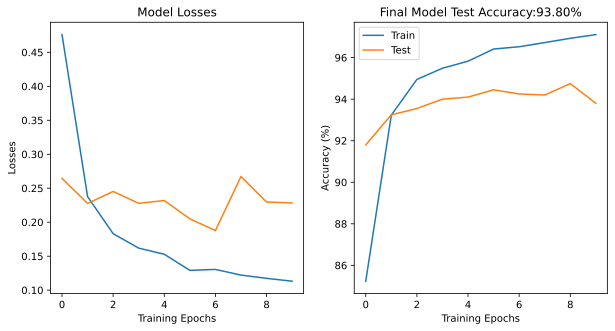

In [32]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(losses_base)
ax[0].set_xlabel("Training Epochs")
ax[0].set_ylabel("Losses")
ax[0].set_title("Model Losses")

ax[1].plot(trainAcc_base, label="Train")
ax[1].plot(testAcc_base,label="Test")
ax[1].set_xlabel("Training Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title(f"Final Model Test Accuracy:{testAcc_base[-1]:.2f}%")
ax[1].legend()

plt.show()